In [1]:
%run 'init.ipynb'
%run 'geometry_checks.ipynb'
%run 'functions.ipynb'


In [2]:
N = 100000
mass_fv = 40000

materials = [
    "Teflon_TPC",
    "SS_OuterCryostat",
    "SS_InnerCryostat",
    "OuterCryostatReflector",
    "SS_BellPlate",
    "SS_BellSideWall",
    "PmtTpc",
    "Copper_TopRing",
    "Copper_LowerRing",
    "Teflon_Pillar_",
    "Copper_FieldGuard_",
    "Copper_FieldShaperRing_",
    "Electrodes",
    "Teflon_BottomTPC",   
    "Top_PTFE_Frame",
    "Copper_BottomPmtPlate",
    "Copper_TopPmtPlate",
    ]


DATE = 'XENONnT_2019-11-12'

isotope_array = ["U238",
                "Co60",
                "K40",
                "Cs137",
                "Th228",
                "U235",
                "Th232",
                "Ra226",
                #"geantinos"
                ]
num_file = '1'

array = np.arange(1, 2)

In [3]:
def calculate_events(data, isotope):
    ss = single_scatter(data)
    fv_ = fv(ss)
    energy_ = energy(fv_, 1, 12)
    events_passing = len(energy_)
    if events_passing ==0:
        en_enlarged = energy(fv_, 1, 100)
        events_passing = (len(en_enlarged)*11)/99
        if events_passing == 0:
            events_passing = 2.3
    return events_passing

In [4]:
def calculate_rate(data, material, isotope, n_gen, m_fv):
    n_events = calculate_events(data, isotope)
    b = select_typepri(data, isotope)
    frac = return_frac(material)
    n =  N*(frac/100)*(1/b)
    E = 12
    p = get_parameters(material)
    mass = p['mass']

    contamination = p[isotope]
    err = "err_"+isotope
    err = str(err)
    if (contamination == 0):
        print("|", material, "|", isotope, "|", p[isotope],"+-", p[err],"|","No contamination value", "|" )
        rate = 0
        error_rate = 0
    else:
        time = n_gen / (mass * contamination)
        rate = n_events/(time * m_fv * E)
        alpha = mass / (m_fv * E * n_gen)
        err = "err_"+isotope
        err = str(err)
        error_rate = alpha * np.sqrt((n_events * p[err])**2 + (contamination*np.sqrt(n_events))**2)
        if n_events == 2.3: #it means we set an upper limit
            print("|", material, "|", isotope, "|", p[isotope],"+-", p[err],"| <%2.2f" %rate, "|")
        else:
            print("|", material, "|", isotope, "|", p[isotope],"+-", p[err],"| %2.2f +- %2.2f" %(rate, error_rate), "|")
        return rate, error_rate

In [5]:
def print_results_big_table():    
    for material in materials:
        print("^material ^isotope  ^ contamination ^ rate ^ ")

        for isotope in isotope_array:
                if material == 'Teflon_TPC':
                    rootfile = '/userdata/arocchetti/' + DATE + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +  '_' + num_file+'_Sort' + '.root'
                    data = get_xyz(rootfile)
                    mat = "Teflon_TPC_Sliding"
                    calculate_rate(data, mat,isotope, N, mass_fv)
                    mat = "Teflon_TPC_Fixed"
                    calculate_rate(data, mat,isotope, N, mass_fv)

                elif material == "Top_PTFE_Frame":
                    data = get_TopPFTE(isotope)
                    mat = "Top_PTFE_Frame"
                    calculate_rate(data, mat,isotope, N, 4000)

                elif material == "Electrodes":
                    data = get_electrodes(isotope)
                    mat = "SS_Electrodes"
                    calculate_rate(data, mat,isotope, N, 4000)

                elif material == 'SS_OuterCryostat':
                    rootfile = '/userdata/arocchetti/' + DATE + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +  '_' + num_file+'_Sort' + '.root'
                    data = get_xyz(rootfile)
                    flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
                    flanges = pd.concat([flange1, flange2, flange3])
                    calculate_rate(flanges, "OuterCryostat_flanges",isotope, N, mass_fv)
                    calculate_rate(shell, "OuterCryostatShell",isotope, N, mass_fv)
                    calculate_rate(elongation, "OuterCryostat_Elongation",isotope, N, mass_fv)

                elif material == 'SS_InnerCryostat':
                    rootfile = '/userdata/arocchetti/' + DATE + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +  '_' + num_file+'_Sort' + '.root'
                    data = get_xyz(rootfile)
                    flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
                    flange_in = pd.concat([flange1_in, flange2_in, flange3_in])
                    calculate_rate(flange_in, "SS_InnerCryostatFlanges",isotope,N, mass_fv)
                    calculate_rate(shell_in, "SS_InnerCryostatShell",isotope,N, mass_fv)
                    calculate_rate(elongation_in, "SS_InnerCryostat_bottomDome",isotope, N, mass_fv)

                elif material == 'SS_BellSideWall':
                    rootfile = '/userdata/arocchetti/' + DATE + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +  '_' + num_file+'_Sort' + '.root'
                    data = get_xyz(rootfile)
                    bottomLip, bellWall = divide_bellWall(data)
                    calculate_rate(bottomLip, "SS_BellSideWallBottomLip",isotope, N, mass_fv)
                    calculate_rate(bellWall, "SS_BellSideWall",isotope, N, mass_fv)

                else: 
                    rootfile = '/userdata/arocchetti/' + DATE + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +  '_' + num_file+'_Sort' + '.root'
                    data = get_xyz(rootfile)
                    calculate_rate(data, material,isotope,N, mass_fv)

#print_results_big_table()

In [ ]:
def print_results_big_table():    
    for material in materials:
        print("^material ^isotope  ^ contamination ^ rate ^ ")

        for isotope in isotope_array:
                if material == 'Teflon_TPC':
                    rootfile = '/userdata/arocchetti/' + DATE + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +  '_' + num_file+'_Sort' + '.root'
                    data = get_xyz(rootfile)
                    mat = "Teflon_TPC_Sliding"
                    calculate_rate(data, mat,isotope, N, mass_fv)
                    mat = "Teflon_TPC_Fixed"
                    calculate_rate(data, mat,isotope, N, mass_fv)

                elif material == "Top_PTFE_Frame":
                    data = get_TopPFTE(isotope)
                    mat = "Top_PTFE_Frame"
                    calculate_rate(data, mat,isotope, N, 4000)

                elif material == "Electrodes":
                    data = get_electrodes(isotope)
                    mat = "SS_Electrodes"
                    calculate_rate(data, mat,isotope, N, 4000)

                elif material == 'SS_OuterCryostat':
                    rootfile = '/userdata/arocchetti/' + DATE + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +  '_' + num_file+'_Sort' + '.root'
                    data = get_xyz(rootfile)
                    flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
                    flanges = pd.concat([flange1, flange2, flange3])
                    calculate_rate(flanges, "OuterCryostat_flanges",isotope, N, mass_fv)
                    calculate_rate(shell, "OuterCryostatShell",isotope, N, mass_fv)
                    calculate_rate(elongation, "OuterCryostat_Elongation",isotope, N, mass_fv)

                elif material == 'SS_InnerCryostat':
                    rootfile = '/userdata/arocchetti/' + DATE + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +  '_' + num_file+'_Sort' + '.root'
                    data = get_xyz(rootfile)
                    flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
                    flange_in = pd.concat([flange1_in, flange2_in, flange3_in])
                    calculate_rate(flange_in, "SS_InnerCryostatFlanges",isotope,N, mass_fv)
                    calculate_rate(shell_in, "SS_InnerCryostatShell",isotope,N, mass_fv)
                    calculate_rate(elongation_in, "SS_InnerCryostat_bottomDome",isotope, N, mass_fv)

                elif material == 'SS_BellSideWall':
                    rootfile = '/userdata/arocchetti/' + DATE + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +  '_' + num_file+'_Sort' + '.root'
                    data = get_xyz(rootfile)
                    bottomLip, bellWall = divide_bellWall(data)
                    calculate_rate(bottomLip, "SS_BellSideWallBottomLip",isotope, N, mass_fv)
                    calculate_rate(bellWall, "SS_BellSideWall",isotope, N, mass_fv)

                else: 
                    rootfile = '/userdata/arocchetti/' + DATE + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +  '_' + num_file+'_Sort' + '.root'
                    data = get_xyz(rootfile)
                    calculate_rate(data, material,isotope,N, mass_fv)

#print_results_big_table()

In [27]:
material_array = ["SS_OuterCryostat",
                "SS_InnerCryostat",
                "OuterCryostatReflector",
                "SS_BellPlate",
                "SS_BellSideWall",
                "PmtTpc",
                "Copper_TopRing",
                "Copper_LowerRing",
                "Teflon_Pillar_",
                "Copper_FieldGuard_",
                "Copper_FieldShaperRing_",
                "SS_GateRing",
                "SS_AnodeRing",
                "SS_TopMeshRing",
                "SS_CathodeRing",
                "SS_BottomMeshRing",
                "Teflon_BottomTPC",
                "Teflon_TPC",
                "GXeTeflon_TopElectrodesFrame",
                "Teflon_TopElectrodesFrame",
                "Copper_BottomPmtPlate",
                "Copper_TopPmtPlate",
                ]

isotope_array = ["U238",
                "Co60",
                "K40",
                "Cs137",
                "Th228",
                "U235",
                "Th232",
                "Ra226",
                #"geantinos"
                ]
num_file = '1'


data_ = pd.DataFrame()
for material in material_array:
    print("working on:" , material)
    for isotope in isotope_array:
        rootfile = '/userdata/arocchetti/' + DATE + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +  '_' + num_file+'_Sort' + '.root'
        data = get_xyz(rootfile)
        data_ = pd.concat([data_, data])
    return data_
    

working on: SS_OuterCryostat
6430
working on: SS_InnerCryostat
18113
working on: OuterCryostatReflector
26102
working on: SS_BellPlate
53283
working on: SS_BellSideWall
70550
working on: PmtTpc
100923
working on: Copper_TopRing
129713
working on: Copper_LowerRing
134345
working on: Teflon_Pillar_
187979
working on: Copper_FieldGuard_
239720
working on: Copper_FieldShaperRing_
316228
working on: SS_GateRing
350857
working on: SS_AnodeRing
380034
working on: SS_TopMeshRing
406274
working on: SS_CathodeRing
436232
working on: SS_BottomMeshRing
451220
working on: Teflon_BottomTPC
486768
working on: Teflon_TPC
596860
working on: GXeTeflon_TopElectrodesFrame
627345
working on: Teflon_TopElectrodesFrame
657986
working on: Copper_BottomPmtPlate
665044
working on: Copper_TopPmtPlate
694485


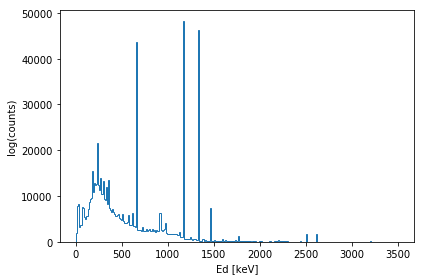

tot_events: 694485


In [41]:
def plot_spectrum(data, min,max, bins):
    plt.hist(data.Ed, bins = bins, range = (min, max), histtype = 'step')
    plt.ylabel('log(counts)')
    plt.xlabel('Ed [keV]')
    #plt.yscale('log')
    plt.tight_layout()
    plt.show()
    print("tot_events:", len(data))
plot_spectrum(data_, 0, 3500, 300)      

In [15]:
x = np.arange(0,100, 2)
print(x)
y = x*3
print(y)

[ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46
 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94
 96 98]
[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294]


<function matplotlib.pyplot.show(*args, **kw)>

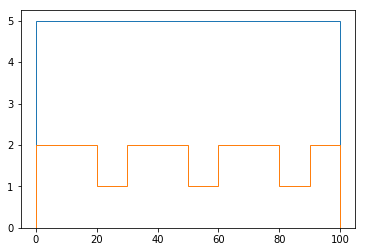

In [16]:
plt.hist(x, range=(0,100),histtype = 'step', label = "x")
plt.hist(y, range=(0,100),histtype = 'step', label = "y")
plt.show

In [18]:
z = x+y
z.show()

AttributeError: 'numpy.ndarray' object has no attribute 'show'

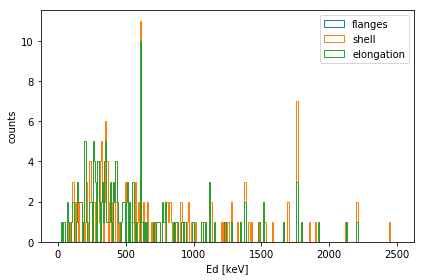

In [12]:
DATE = 'XENONnT_2019-11-12'
materials = ["SS_OuterCryostat",
    ]
for material in materials:
    bins = 300
    min = 0
    max = 2500
    
    if material == "Top_PTFE_Frame":
        data_topPTFE = get_TopPFTE()
        material = "Top_PTFE_Frame"
        
            
        plt.hist(data_topPTFE.Ed, bins = 300, range = (0, 350), histtype = 'step', label = material)
            
    elif material == "Electrodes":
            data_electrodes = get_electrodes()
            material = "SS_Electrodes"
            plt.hist(data_electrodes.Ed,bins = bins, range = (min, max), histtype = 'step', label = material)
            
    elif material == 'SS_OuterCryostat':
        for isotope in isotope_array:
            rootfile = '/userdata/arocchetti/' + DATE + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +  '_' + num_file+'_Sort' + '.root'
            data = get_xyz(rootfile)
            flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
            flange = pd.DataFrame()
            flanges = pd.concat([flange1, flange2, flange3])
        
            
            #plt.hist(flanges.Ed, bins = bins, range = (min, max), histtype = 'step', label = "flanges")
            #plt.hist(shell.Ed, bins = bins, range = (min, max), histtype = 'step', label = "shell")
            #plt.hist(elongation.Ed, bins = bins, range = (min, max), histtype = 'step', label = "elongation")
            
    elif material == 'SS_InnerCryostat':
            rootfile = '/userdata/arocchetti/' + DATE + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +  '_' + num_file+'_Sort' + '.root'
            data = get_xyz(rootfile)
            flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
            flange_in = pd.concat([flange1_in, flange2_in, flange3_in])
            #plt.hist(flange_in.Ed, bins = bins, range = (min, max), histtype = 'step', label = "flange_in")
            #plt.hist(shell_in.Ed, bins = bins, range = (min, max), histtype = 'step', label = "shell_in")
            #plt.hist(elongation_in.Ed, bins = bins, range = (min, max), histtype = 'step', label = "elongation_in")
            #plt.ylabel('counts')
            #plt.xlabel('Ed [keV]')
            #plt.yscale('log')
            #plt.tight_layout()
            
    elif material == 'SS_BellSideWall':
            rootfile = '/userdata/arocchetti/' + DATE + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +  '_' + num_file+'_Sort' + '.root'
            data = get_xyz(rootfile)
            bottomLip, bellWall = divide_bellWall(data)

    elif material == 'Teflon_TPC':
            rootfile = '/userdata/arocchetti/' + DATE + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +  '_' + num_file+'_Sort' + '.root'
            data_teflonTPC = get_xyz(rootfile)
            

    else:
        data_per_material = pd.DataFrame()
        for isotope in isotope_array:
            rootfile = '/userdata/arocchetti/' + DATE + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +  '_' + num_file+'_Sort' + '.root'
            data = get_xyz(rootfile)
            plt.hist(flanges.Ed, bins = bins, range = (min, max), histtype = 'step', label = material)
            data_per_material = pd.contact([data_per_material, data])
        
            

plt.hist(flanges.Ed, bins = bins, range = (min, max), histtype = 'step', label = "flanges")
plt.hist(shell.Ed, bins = bins, range = (min, max), histtype = 'step', label = "shell")
plt.hist(elongation.Ed, bins = bins, range = (min, max), histtype = 'step', label = "elongation")
#plt.hist(flange_in.Ed, bins = bins, range = (min, max), histtype = 'step', label = "flange_in")
#plt.hist(shell_in.Ed, bins = bins, range = (min, max), histtype = 'step', label = "shell_in")
#plt.hist(elongation_in.Ed, bins = bins, range = (min, max), histtype = 'step', label = "elongation_in")
plt.ylabel('counts')
plt.xlabel('Ed [keV]')
#plt.yscale('log')
plt.tight_layout()
plt.legend()


In [ ]:
print(len(shell))

In [7]:
3.3*(2.3/48.3)

0.1571428571428571